In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 13.2 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
import glob
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from functools import reduce
import warnings
warnings.filterwarnings('ignore')

from lightgbm import LGBMClassifier
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ParameterSampler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
import optuna
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

from tqdm import tqdm
from collections import defaultdict
from itertools import combinations

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
# from pytorch_tabnet.tab_network import TabNetEncoder

In [4]:
seed = 810

def set_seed(sd):
    random.seed(sd)
    np.random.seed(sd)
    os.environ['PYTHONHASHSEED'] = str(sd)
    random.seed(sd)
    np.random.seed(sd)
    torch.manual_seed(sd)
    torch.cuda.manual_seed_all(sd)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(seed)

In [5]:
data_dir = '/content/drive/MyDrive/1데이콘/ETRI_휴먼이해_인공지능/ETRI_lifelog_dataset/'

In [6]:
prep_df = pd.read_csv(data_dir + 'prep_df.csv')
metrics_train = pd.read_csv(data_dir + 'ch2025_metrics_train.csv')
sample_submission = pd.read_csv(data_dir + 'ch2025_submission_sample.csv')

# train/test 데이터셋

In [7]:
# datetime 형으로 변환
metrics_train['lifelog_date'] = pd.to_datetime(metrics_train['lifelog_date']).dt.date
prep_df['date'] = pd.to_datetime(prep_df['date']).dt.date
# prep_df.loc[:, 'date'] = pd.to_datetime(prep_df.loc[:, 'date']).dt.date

In [8]:
# train_df
metrics_train_renamed = metrics_train.rename(columns = {'lifelog_date': 'date'})

train_df = pd.merge(metrics_train_renamed, prep_df, on=['subject_id', 'date'], how='inner')
print(train_df.shape)

(450, 164)


In [9]:
# test_df
prep_key = prep_df[['subject_id','date']]
train_key = metrics_train_renamed[['subject_id','date']]

prep_train_key = pd.merge(prep_key, train_key, on=['subject_id','date'], how='left', indicator=True)
test_key = prep_train_key[prep_train_key['_merge'] == 'left_only'].drop(columns=['_merge'])
print(test_key.shape)

test_df = pd.merge(test_key, prep_df, on=['subject_id','date'], how='left')
print(test_df.shape)

(250, 2)
(250, 157)


In [10]:
def clear_columns_names(df):
  df.columns = (df.columns
                .str.replace(r"[^\w]", "_", regex=True)
                .str.replace(r'__+','_', regex=True)
                .str.strip('_')
                )
  return df

train_df = clear_columns_names(train_df)
test_df = clear_columns_names(test_df)

# 데이터 증강

# x/y 설정

In [ ]:
x = train_df.select_dtypes(include=['number','bool','category'])
test_x = test_df[x.columns]

In [ ]:
x = train_df.select_dtypes(include=['number','bool','category'])
test_x = test_df[x.columns]

x = train_df.select_dtypes(include=['number','bool','category'])
test_x = test_df[x.columns]

x = train_df.drop(columns=['subject_id', 'sleep_date', 'date', 'Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3'])
x.fillna(0, inplace=True)

y = train_df[['Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']]
y.fillna(0, inplace=True)

test_x = test_df.drop(columns=['subject_id', 'date'])
test_x.fillna(0, inplace=True)

In [ ]:
# 컬럼 확인
def find_duplicate(df):
  return df.columns[df.columns.duplicated()].tolist()

dup_x = find_duplicate(x)
dup_test_x = find_duplicate(test_x)
print('x_중복컬럼:', dup_x)
print('test_x_중복컬럼:', dup_test_x)

# 컬럼 집합
x_columns = set(x.columns)
test_x_columns = set(test_x.columns)

only_x = x_columns - test_x_columns
only_test_x = test_x_columns - x_columns
print('only_x:', only_x)
print('only_x_test:', only_test_x)

x_중복컬럼: []
test_x_중복컬럼: []
only_x: set()
only_x_test: set()


# LGBM

## train/test 분할

In [ ]:
# 타켓 목록
targets_binary = ['Q1', 'Q2', 'Q3', 'S2', 'S3']
target_multi = ['S1']

split_data = {}
for col in targets_binary + target_multi:
    y = train_df[col]
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, stratify=y, random_state=seed)
    split_data[col] = (x_train, x_val, y_train, y_val)

## 초기 LGBM

In [ ]:
# 결과 저장
preds = {}
imp = {}

# 파라미터
params = {
    'random_state': seed,
    'n_jobs': -1,
    'verbosity': -1
}

In [ ]:
# 이진분류
 for col in targets_binary:
  y = train_df[col]
  x_train, x_val, y_train, y_val = split_data[col]

  clf_bin = LGBMClassifier(**params)
  clf_bin.fit(x_train, y_train)

  train_acc = clf_bin.score(x_train, y_train)
  val_acc = clf_bin.score(x_val, y_val)
  print(f'{col} -> Train Acc: {train_acc:4f} | Validation Accucary: {val_acc:.4f}')

  imp[col] = pd.DataFrame({'features': x.columns, 'importances': clf_bin.feature_importances_}).sort_values('importances', ascending=False)
  print(f'Top Features for {col}: \n',imp[col].head(10))
  print('-'*50)

  preds[col] = clf_bin.predict(test_x)

Q1 -> Train Acc: 1.000000 | Validation Accucary: 0.5333
Top Features for Q1: 
                    features  importances
140      9to18_wlight_ratio           46
85   charging_transitions_y           40
70        18to24_mlight_max           34
92                카카오톡_time           28
144      24to6_wlight_ratio           26
31        class_Unknown_cnt           25
23                    Music           25
20        Inside_small_room           25
84         charging_ratio_y           23
98                  통화_time           22
--------------------------------------------------
Q2 -> Train Acc: 1.000000 | Validation Accucary: 0.6000
Top Features for Q2: 
                features  importances
89           total_time           44
133  18to24_wlight_mean           29
92            카카오톡_time           28
50        altitude_mean           28
94           NAVER_time           28
134   18to24_wlight_std           27
52     altitude_std_max           26
113        9to18_hr_std           24
141   2

In [ ]:
# 다중 분류 (S1)
for col in target_multi:
  y = train_df[col]
  x_train, x_val, y_train, y_val = split_data[col]

  clf_multi = LGBMClassifier(**params, objectvie= 'multiclass', num_class=3)
  clf_multi.fit(x_train, y_train)

  train_acc = clf_bin.score(x_train, y_train)
  val_acc = clf_bin.score(x_val, y_val)
  print(f'{col} -> Train Acc: {train_acc:4f} | Validation Accucary: {val_acc:.4f}')

  imp[col] = pd.DataFrame({'features': x.columns, 'importances': clf_multi.feature_importances_}).sort_values('importances', ascending=False)
  print(f'Top Features for {col}: \n',imp[col].head(10))

  preds[col] = clf_multi.predict(test_x)

S1 -> Train Acc: 0.486111 | Validation Accucary: 0.4778
Top Features for S1: 
                     features  importances
42       class_Unknown_ratio          107
99                  메시지_time           69
148        6to9_wlight_ratio           67
70         18to24_mlight_max           64
90               others_time           64
30                    others           63
54              altitude_max           62
144       24to6_wlight_ratio           62
2    avg_charging_period_min           61
74          9to18_mlight_max           61


## 피처 탐색

In [ ]:
def all_zero_features(df):

  imp_zero = {}
  for col, values in imp.items():
    imp_zero[col] = values[values['importances'] == 0]

  features_key = defaultdict(set)

  for key, df in imp_zero.items():
    features_key[key] = set(df['features'])

  all_keys = list(features_key.keys())
  common_all = set.intersection(*(features_key[k] for k in all_keys))

  common_features = {}
  for k1, k2 in combinations(features_key.keys(), 2):
    inter = features_key[k1] & features_key[k2]
    if inter:
        common_features[(k1, k2)] = inter

  # 분수별 공통 피처
  for (k1, k2), df in common_features.items():
    print(f"{k1} & {k2} 공통 features: {len(df)}개")
    print(sorted(df))
    print("=" * 50)

  # 모든 공통 피처
  print()
  print(f"모든 변수에 공통으로 등장하는 feature: {len(common_all)}개")
  print(pd.DataFrame(sorted(common_all)))

  return common_features, common_all

In [ ]:
common_features, common_all = all_zero_features(prep_df)

Q1 & Q2 공통 features: 16개
['18to24_frequence_activity', '18to24_in_activity', '24to6_activity_total', '24to6_frequence_activity', '24to6_hr_std', 'class_Audio_Video_cnt', 'class_Computer_cnt', 'class_Computer_ratio', 'class_Health_cnt', 'class_Health_ratio', 'class_Peripheral_cnt', 'class_others_cnt', 'class_others_ratio', '성경일독Q_time', '캐시워크_time', '타임스프레드_time']
Q1 & Q3 공통 features: 14개
['18to24_frequence_activity', '24to6_frequence_activity', '9to18_frequence_activity', 'class_Audio_Video_cnt', 'class_Computer_cnt', 'class_Computer_ratio', 'class_Health_cnt', 'class_Health_ratio', 'class_Peripheral_ratio', 'class_others_cnt', 'class_others_ratio', '성경일독Q_time', '캐시워크_time', '타임스프레드_time']
Q1 & S2 공통 features: 13개
['24to6_activity_total', '24to6_frequence_activity', '9to18_frequence_activity', 'class_Computer_cnt', 'class_Computer_ratio', 'class_Health_cnt', 'class_Health_ratio', 'class_Peripheral_cnt', 'class_Peripheral_ratio', 'class_others_cnt', 'class_others_ratio', '성경일독Q_time', 

In [ ]:
# prep_df = prep_df.drop(columns=common_all)
prep_df.shape

(700, 157)

## 파라미터 탐색

### optuna

In [ ]:
def objective_binary(trial):
  lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
  n_estimators = trial.suggest_int('n_estimators', 50, 300)
  max_depth = trial.suggest_int('max_depth', 2, 32)

  clf_binary = LGBMClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        lerning_rate = lr,
        random_state=seed,
        n_jobs=-1,
        verbosity= -1
    )

  score = cross_val_score(clf_binary, x_train, y_train, cv=5, scoring='f1').mean()

  trial.report(score, step=0)
  if trial.should_prune():
    raise optuna.exceptions.TrialPruned()

  return -score

In [ ]:
best_param_dict = {}

for col in targets_binary:
    x_train, _, y_train, _ = split_data[col]

    study = optuna.create_study(direction="minimize")
    study.optimize(objective_binary, n_trials=50)

    best_params = study.best_params
    best_score = -study.best_value
    best_param_dict[col] = best_params
    print(f"{col} 최적 파라미터: {best_params}")
    print(f"{col} 최고 F1 점수: {best_score:.4f}")
    print("=" * 50, "\n")

[I 2025-06-05 06:14:28,813] A new study created in memory with name: no-name-d9411a93-e26b-403d-a3a0-8107b190bb85
[I 2025-06-05 06:14:29,321] Trial 0 finished with value: -0.5930224161803109 and parameters: {'lr': 6.364535011592363e-05, 'n_estimators': 65, 'max_depth': 14}. Best is trial 0 with value: -0.5930224161803109.
[I 2025-06-05 06:14:30,094] Trial 1 finished with value: -0.5966201667335299 and parameters: {'lr': 0.018905211874433624, 'n_estimators': 120, 'max_depth': 13}. Best is trial 1 with value: -0.5966201667335299.
[I 2025-06-05 06:14:30,617] Trial 2 finished with value: -0.5925975089383011 and parameters: {'lr': 0.04397898743417584, 'n_estimators': 134, 'max_depth': 3}. Best is trial 1 with value: -0.5966201667335299.
[I 2025-06-05 06:14:31,845] Trial 3 finished with value: -0.5907166339243834 and parameters: {'lr': 9.946571584776801e-05, 'n_estimators': 205, 'max_depth': 24}. Best is trial 1 with value: -0.5966201667335299.
[I 2025-06-05 06:14:36,990] Trial 4 finished wi

Q1 최적 파라미터: {'lr': 0.018905211874433624, 'n_estimators': 120, 'max_depth': 13}
Q1 최고 F1 점수: 0.5966



[I 2025-06-05 06:15:37,399] Trial 0 finished with value: -0.6499028061708091 and parameters: {'lr': 0.05992831505823021, 'n_estimators': 281, 'max_depth': 13}. Best is trial 0 with value: -0.6499028061708091.
[I 2025-06-05 06:15:38,204] Trial 1 finished with value: -0.6552913725692412 and parameters: {'lr': 0.00032667314044675685, 'n_estimators': 243, 'max_depth': 3}. Best is trial 1 with value: -0.6552913725692412.
[I 2025-06-05 06:15:38,866] Trial 2 finished with value: -0.6542939173946926 and parameters: {'lr': 0.00022944541953781933, 'n_estimators': 98, 'max_depth': 16}. Best is trial 1 with value: -0.6552913725692412.
[I 2025-06-05 06:15:39,175] Trial 3 finished with value: -0.6673491814883963 and parameters: {'lr': 0.00010650799238383275, 'n_estimators': 51, 'max_depth': 3}. Best is trial 3 with value: -0.6673491814883963.
[I 2025-06-05 06:15:40,150] Trial 4 finished with value: -0.6659836941994118 and parameters: {'lr': 0.0011066949893032874, 'n_estimators': 152, 'max_depth': 29

Q2 최적 파라미터: {'lr': 0.00010650799238383275, 'n_estimators': 51, 'max_depth': 3}
Q2 최고 F1 점수: 0.6673



[I 2025-06-05 06:16:41,251] Trial 0 finished with value: -0.6865717769741821 and parameters: {'lr': 5.618796426739489e-05, 'n_estimators': 202, 'max_depth': 21}. Best is trial 0 with value: -0.6865717769741821.
[I 2025-06-05 06:16:42,063] Trial 1 finished with value: -0.6714125731793116 and parameters: {'lr': 0.014426391439878606, 'n_estimators': 180, 'max_depth': 4}. Best is trial 0 with value: -0.6865717769741821.
[I 2025-06-05 06:16:43,899] Trial 2 finished with value: -0.6893126611902745 and parameters: {'lr': 0.005750915308901471, 'n_estimators': 297, 'max_depth': 12}. Best is trial 2 with value: -0.6893126611902745.
[I 2025-06-05 06:16:45,116] Trial 3 finished with value: -0.6719182241225329 and parameters: {'lr': 0.0009035684408161607, 'n_estimators': 211, 'max_depth': 6}. Best is trial 2 with value: -0.6893126611902745.
[I 2025-06-05 06:16:46,405] Trial 4 finished with value: -0.6880367859091263 and parameters: {'lr': 0.029866291799968293, 'n_estimators': 195, 'max_depth': 12}.

Q3 최적 파라미터: {'lr': 0.005750915308901471, 'n_estimators': 297, 'max_depth': 12}
Q3 최고 F1 점수: 0.6893



[I 2025-06-05 06:17:54,379] Trial 0 finished with value: -0.756822225393654 and parameters: {'lr': 0.006976064793452291, 'n_estimators': 73, 'max_depth': 29}. Best is trial 0 with value: -0.756822225393654.
[I 2025-06-05 06:17:55,823] Trial 1 finished with value: -0.7632843922771603 and parameters: {'lr': 6.208007041066934e-05, 'n_estimators': 249, 'max_depth': 9}. Best is trial 1 with value: -0.7632843922771603.
[I 2025-06-05 06:17:57,079] Trial 2 finished with value: -0.7622195446077773 and parameters: {'lr': 0.0767838977821972, 'n_estimators': 203, 'max_depth': 16}. Best is trial 1 with value: -0.7632843922771603.
[I 2025-06-05 06:17:58,108] Trial 3 finished with value: -0.7583175216503479 and parameters: {'lr': 0.006449141011737097, 'n_estimators': 170, 'max_depth': 22}. Best is trial 1 with value: -0.7632843922771603.
[I 2025-06-05 06:18:02,333] Trial 4 finished with value: -0.7637014547754586 and parameters: {'lr': 0.04925138736849065, 'n_estimators': 200, 'max_depth': 22}. Best 

S2 최적 파라미터: {'lr': 0.04925138736849065, 'n_estimators': 200, 'max_depth': 22}
S2 최고 F1 점수: 0.7637



[I 2025-06-05 06:19:16,185] Trial 0 finished with value: -0.7649539405005367 and parameters: {'lr': 0.014842633614138338, 'n_estimators': 258, 'max_depth': 20}. Best is trial 0 with value: -0.7649539405005367.
[I 2025-06-05 06:19:17,124] Trial 1 finished with value: -0.7858195147146027 and parameters: {'lr': 0.002041930215966854, 'n_estimators': 149, 'max_depth': 30}. Best is trial 1 with value: -0.7858195147146027.
[I 2025-06-05 06:19:17,727] Trial 2 finished with value: -0.7628447487236995 and parameters: {'lr': 0.012561080455706558, 'n_estimators': 93, 'max_depth': 32}. Best is trial 1 with value: -0.7858195147146027.
[I 2025-06-05 06:19:19,423] Trial 3 finished with value: -0.7833710611063552 and parameters: {'lr': 0.009501342117443188, 'n_estimators': 158, 'max_depth': 11}. Best is trial 1 with value: -0.7858195147146027.
[I 2025-06-05 06:19:22,172] Trial 4 finished with value: -0.7784138088670087 and parameters: {'lr': 0.028073193371112505, 'n_estimators': 63, 'max_depth': 26}. B

S3 최적 파라미터: {'lr': 0.002041930215966854, 'n_estimators': 149, 'max_depth': 30}
S3 최고 F1 점수: 0.7858



In [ ]:
def objective_multi(trial):
  lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
  n_estimators = trial.suggest_int('n_estimators', 50, 300)
  max_depth = trial.suggest_int('max_depth', 2, 32)

  clf_multi = LGBMClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        lerning_rate = lr,
        random_state=seed,
        n_jobs=-1,
        verbosity= -1,
        objective= 'multiclass',
        num_class=3
    )

  score = cross_val_score(clf_multi, x_train, y_train, cv=5, scoring='f1_macro').mean()

  trial.report(score, step=0)
  if trial.should_prune():
    raise optuna.exceptions.TrialPruned()

  return -score

In [ ]:
for col in target_multi:
    x_train, _, y_train, _ = split_data[col]

    study = optuna.create_study(direction="minimize")
    study.optimize(objective_multi, n_trials=50)

    best_params = study.best_params
    best_score = -study.best_value
    best_param_dict[col] = best_params
    print(f"{col} 최적 파라미터: {best_params}")
    print(f"{col} 최고 F1 점수: {best_score:.4f}")
    print("=" * 50, "\n")

[I 2025-06-05 06:20:22,841] A new study created in memory with name: no-name-3ea45e4a-cb5a-48f6-b1cc-03ffc0506499
[I 2025-06-05 06:20:29,443] Trial 0 finished with value: -0.4233193360044275 and parameters: {'lr': 0.06136752017618622, 'n_estimators': 191, 'max_depth': 11}. Best is trial 0 with value: -0.4233193360044275.
[I 2025-06-05 06:20:31,955] Trial 1 finished with value: -0.4314112694835209 and parameters: {'lr': 3.373231683213097e-05, 'n_estimators': 142, 'max_depth': 23}. Best is trial 1 with value: -0.4314112694835209.
[I 2025-06-05 06:20:34,643] Trial 2 finished with value: -0.41972236873825597 and parameters: {'lr': 1.4420750683095696e-05, 'n_estimators': 162, 'max_depth': 6}. Best is trial 1 with value: -0.4314112694835209.
[I 2025-06-05 06:20:37,115] Trial 3 finished with value: -0.4050397365663162 and parameters: {'lr': 0.0011577622653338021, 'n_estimators': 201, 'max_depth': 4}. Best is trial 1 with value: -0.4314112694835209.
[I 2025-06-05 06:20:43,376] Trial 4 finished

S1 최적 파라미터: {'lr': 3.373231683213097e-05, 'n_estimators': 142, 'max_depth': 23}
S1 최고 F1 점수: 0.4314



### RandomSearch

In [ ]:
random_param = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.03, 0.05],
    'max_depth': [1, 3, 5]
}

n_iter = 30
param_list = list(ParameterSampler(random_param, n_iter=n_iter, random_state=seed))

best_param_dict = {}

In [ ]:
# binary_
for col in targets_binary:
  x_train, _, y_train, _ = split_data[col]

  best_score = -np.inf
  best_params = None

  for params in tqdm(param_list, desc=f'RandomizedSearchCV for {col}'):
    clf_bin = LGBMClassifier(**params)
    scores = cross_val_score(clf_bin, x_train, y_train, cv=5, scoring='accuracy')
    mean_score = scores.mean()

    if mean_score > best_score:
      best_score = mean_score
      best_params = params

  best_param_dict[col] = best_params
  print(f'{col} 최적 파라미터:', best_params)
  print(f'{col} 최고 성능: {best_score:.4f}')
  print('=' * 50, '\n')

RandomizedSearchCV for Q1: 100%|██████████| 27/27 [00:19<00:00,  1.38it/s]


Q1 최적 파라미터: {'n_estimators': 100, 'max_depth': 1, 'learning_rate': 0.05}
Q1 최고 성능: 0.6250



RandomizedSearchCV for Q2: 100%|██████████| 27/27 [00:18<00:00,  1.49it/s]


Q2 최적 파라미터: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.03}
Q2 최고 성능: 0.6194



RandomizedSearchCV for Q3: 100%|██████████| 27/27 [00:19<00:00,  1.35it/s]


Q3 최적 파라미터: {'n_estimators': 300, 'max_depth': 1, 'learning_rate': 0.03}
Q3 최고 성능: 0.6083



RandomizedSearchCV for S2: 100%|██████████| 27/27 [00:27<00:00,  1.03s/it]


S2 최적 파라미터: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1}
S2 최고 성능: 0.6917



RandomizedSearchCV for S3: 100%|██████████| 27/27 [00:20<00:00,  1.31it/s]

S3 최적 파라미터: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.03}
S3 최고 성능: 0.6972



In [ ]:
# multi_
for col in target_multi:
  x_train, _, y_train, _ = split_data[col]

  best_score = -np.inf
  best_params = None

  for params in tqdm(param_list, desc=f'RandomizedSearchCV for {col}'):
    clf_multi = LGBMClassifier(**params)
    scores = cross_val_score(clf_bin, x_train, y_train, cv=5, scoring='accuracy')
    mean_score = scores.mean()

    if mean_score > best_score:
      best_score = mean_score
      best_params = params

  best_param_dict[col] = best_params
  print
  print(f'{col} 최적 파라미터:', best_params)
  print(f'{col} 최고 성능: {best_score:.4f}')
  print('=' * 50, '\n')

RandomizedSearchCV for S1: 100%|██████████| 27/27 [02:19<00:00,  5.16s/it]

S1 최적 파라미터: {'n_estimators': 100, 'max_depth': 1, 'learning_rate': 0.1}
S1 최고 성능: 0.5139



## 최종 모델링

In [ ]:
 best_param_dict

{'Q1': {'lr': 0.018905211874433624, 'n_estimators': 120, 'max_depth': 13},
 'Q2': {'lr': 0.00010650799238383275, 'n_estimators': 51, 'max_depth': 3},
 'Q3': {'lr': 0.005750915308901471, 'n_estimators': 297, 'max_depth': 12},
 'S2': {'lr': 0.04925138736849065, 'n_estimators': 200, 'max_depth': 22},
 'S3': {'lr': 0.002041930215966854, 'n_estimators': 149, 'max_depth': 30},
 'S1': {'lr': 3.373231683213097e-05, 'n_estimators': 142, 'max_depth': 23}}

In [ ]:
# 이진분류
for col in targets_binary:
  y = train_df[col]
  x_train, x_val, y_train, y_val = split_data[col]

  clf_bin = LGBMClassifier(**best_param_dict[col] | params)
  # clf_bin.fit(x_train, y_train)
  clf_bin.fit(
    x_train, y_train,
    eval_set=[(x_val, y_val)],
    callbacks=[early_stopping(stopping_rounds=30), log_evaluation(0)],
    )

  train_acc = clf_bin.score(x_train, y_train)
  val_acc = clf_bin.score(x_val, y_val)
  print(f'{col} -> Train Acc: {train_acc:4f} | Validation Accucary: {val_acc:.4f}')

  imp[col] = pd.DataFrame({'features': x.columns, 'importances': clf_bin.feature_importances_}).sort_values('importances', ascending=False)
  print(f'Top Features for {col}: \n',imp[col].head(10))
  print('-'*100)

  preds[col] = clf_bin.predict(test_x)

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.654038
Q1 -> Train Acc: 0.875000 | Validation Accucary: 0.5778
Top Features for Q1: 
                      features  importances
63   center_total_distance_km            8
31          class_Unknown_cnt            6
140        9to18_wlight_ratio            6
41                 rssi_max_x            5
145          6to9_wlight_mean            4
33            class_Phone_cnt            4
70          18to24_mlight_max            4
44          class_Phone_ratio            3
56                speed_max_x            3
98                    통화_time            3
----------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.675872
Q2 -> Train Acc: 0.688889 | Validation Accucary: 0.5778
Top Features for Q2: 

In [ ]:
# 다중 분류 (S1)

for col in target_multi:
  y = train_df[col]
  x_train, x_val, y_train, y_val = split_data[col]

  clf_multi = LGBMClassifier(**best_param_dict[col] | params, objective= 'multiclass', num_class=3)
  clf_multi.fit(x_train, y_train)

  train_acc = clf_bin.score(x_train, y_train)
  val_acc = clf_bin.score(x_val, y_val)
  print(f'{col} -> Train Acc: {train_acc:4f} | Validation Accucary: {val_acc:.4f}')

  imp[col] = pd.DataFrame({'features': x.columns, 'importances': clf_multi.feature_importances_}).sort_values('importances', ascending=False)
  print(f'Top Features for {col}: \n',imp[col].head(10))

  preds[col] = clf_multi.predict(test_x)

S1 -> Train Acc: 0.480556 | Validation Accucary: 0.4667
Top Features for S1: 
                     features  importances
42       class_Unknown_ratio          143
99                  메시지_time          106
90               others_time           95
148        6to9_wlight_ratio           94
2    avg_charging_period_min           93
70         18to24_mlight_max           93
0           charging_ratio_x           90
105               rssi_max_y           89
74          9to18_mlight_max           89
91             One_UI_홈_time           88


In [ ]:
for col in preds.keys():
  unique, counts = np.unique(preds[col], return_counts=True)
  print(dict(zip(unique, counts)))

{np.int64(0): np.int64(119), np.int64(1): np.int64(131)}
{np.int64(0): np.int64(95), np.int64(1): np.int64(155)}
{np.int64(0): np.int64(79), np.int64(1): np.int64(171)}
{np.int64(0): np.int64(59), np.int64(1): np.int64(191)}
{np.int64(0): np.int64(63), np.int64(1): np.int64(187)}
{np.int64(0): np.int64(77), np.int64(1): np.int64(153), np.int64(2): np.int64(20)}


# Seq2seq(GRU) + Attention

In [ ]:
targets = ['Q1','Q2','Q3','S1','S2','S3']

class SeqDataset_train(Dataset):
    def __init__(self, df, targets):
        # self.samples = []
        # self.seq_len = seq_len
        self.targets = targets
        self.feature_cols = [col for col in df.columns if col not in ['subject_id', 'date', 'sleep_date', 'lifelog_date'] + targets]

        self.x = df[self.feature_cols].to_numpy(dtype=np.float32)
        self.y = df[targets].to_numpy(dtype=np.float32)

        # for sub, group in df.groupby('subject_id'):
        #     group = group.sort_values('date').reset_index(drop=True)
        #     max_i = len(group) - seq_len - 1
        #     for i in range(max_i + 1):
        #         x_seq = group.iloc[i:i+seq_len][self.feature_cols].to_numpy(dtype=np.float32)
        #         y = group.iloc[i+seq_len][self.targets].to_numpy(dtype=np.float32)
        #         self.samples.append((x_seq, y))

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
      return torch.tensor(self.x[idx]), torch.tensor(self.y[idx])

class SeqDataset_test(Dataset):
    def __init__(self, df, targets):
        # self.samples = []
        # self.seq_len = seq_len
        self.targest = targets
        self.feature_cols = [col for col in df.columns if col not in ['subject_id', 'date', 'sleep_date', 'lifelog_date'] + targets]
        self.x = df[self.feature_cols].to_numpy(dtype=np.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return torch.tensor(self.x[idx])

class FeatureAttention(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        weights = self.attention(x)          # (batch, input_dim)
        return x * weights

class Encoder(nn.Module):
  # Numeric
  def __init__(self, input_dim, hidden_dim, num_layers, dropout):
    super().__init__()
    self.num_layers = num_layers
    self.gru = nn.GRU(input_dim,
                      hidden_dim,
                      num_layers,
                      batch_first=True,
                      dropout = dropout if num_layers > 1 else 0)

  def forward(self, src):
    encoder_outputs, hidden = self.gru(src)

    return encoder_outputs, hidden

class Attention(nn.Module):
  # Luong
  def __init__(self, hidden_dim):
    super().__init__()
    self.attn = nn.Linear(hidden_dim * 2, hidden_dim)
    self.v = nn.Linear(hidden_dim, 1, bias=False)

  def forward(self, hidden, encoder_outputs):
    src_len = encoder_outputs.size(1)
    hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
    concat = torch.cat((hidden, encoder_outputs), dim=2)
    atten = self.attn(concat)
    energy = torch.tanh(atten)
    # energy = torch.tanh(self.atten(torch.cat((hidden, encoder_outputs), dim=2)))
    attention = self.v(energy).squeeze(2)

    return torch.softmax(attention, dim=1)

class Decoder(nn.Module):
  #Multi
  def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, num_layers, attention, dropout):
    super().__init__()
    self.embedding = nn.Linear(input_dim, embedding_dim)
    self.gru = nn.GRU(hidden_dim + embedding_dim,
                      hidden_dim,
                      num_layers,
                      batch_first=True,
                      dropout = dropout if num_layers > 1 else 0)
    self.fc_out = nn.Linear(hidden_dim * 2 + embedding_dim, output_dim)
    self.attention = attention
  def forward(self, input, hidden, encoder_outputs):
    embedded = self.embedding(input).unsqueeze(1)
    hidden_ = hidden.squeeze(0)
    attn_weights = self.attention(hidden_, encoder_outputs).unsqueeze(1)
    context = torch.bmm(attn_weights, encoder_outputs)
    gru_input = torch.cat((embedded, context), dim=2)
    output, hidden = self.gru(gru_input, hidden)

    output = output.squeeze(1)
    context = context.squeeze(1)
    embedded = embedded.squeeze(1)

    prediction = self.fc_out(torch.cat((output, context, embedded), dim=1))

    return prediction, hidden, attn_weights.squeeze(1)

class seq2seqMulti(nn.Module):
  def __init__(self, encoder, decoder, feature_attn, device):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.feature_attn = feature_attn
    self.device = device

  def forward(self, src):
    src = self.feature_attn(src)
    src = src.unsqueeze(1)
    encoder_outputs, hidden = self.encoder(src)

    input_last = src[:, -1, :]
    decoder_output, _, _ = self.decoder(input_last, hidden, encoder_outputs)

    return decoder_output

In [ ]:
def find_threshold(model, train_dataset, optimizer, bce_loss_fn, ce_loss_fn, batch_size, device):
    model.train()
    loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

    thresholds = np.linspace(0.1, 1, 10)
    f1_scores_per_threshold = [[] for _ in thresholds]

    for e in range(1, 10  + 1):
      train_loss = 0
      train_accuracy = 0

      for x_batch, y_batch in loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()

        output = model(x_batch)
        # Q1 ~ Q3, S2 ~ S3 - binary
        binary_logits = torch.cat([output[:, 0:3], output[:, 6:8]], dim=1)
        binary_target = torch.cat([y_batch[:, 0:3], y_batch[:, 4:6]], dim=1).float()
        loss_bce = bce_loss_fn(binary_logits, binary_target)

        sigmoid_output = torch.sigmoid(binary_logits)
        for i, t in enumerate(thresholds):
          binary_pred = (sigmoid_output > t).int()
          f1 = f1_score(binary_target, binary_pred, average='weighted', zero_division=0)
          f1_scores_per_threshold[i].append(f1)

        loss_bce.backward()
        optimizer.step()
        train_loss += loss_bce.item()

      avg_loss = train_loss / len(loader)

      if e % 10 == 0 or e == 1 or e == num_epochs:
        print(f'Epoch {e}/{num_epochs}, Loss: {avg_loss:.4f}')

    avg_f1_scores = [np.mean(scores) for scores in f1_scores_per_threshold]
    best_f1 = max(avg_f1_scores)
    best_threshold = thresholds[avg_f1_scores.index(best_f1)]
    print(f"최적의 임계값: {best_threshold:.2f}, F1 Score: {best_f1:.4f}")
    f1_matrix = np.array(f1_scores_per_threshold).T
    avg_f1_scores = f1_matrix.mean(axis=0)
    plt.plot(thresholds, avg_f1_scores)
    plt.title("F1 Score vs. Sigmoid Threshold")
    plt.xlabel("Threshold")
    plt.ylabel("F1 Score")
    plt.grid(True)
    plt.show()

    return best_threshold

In [ ]:
def train(model, train_dataset, optimizer, bce_loss_fn, ce_loss_fn, batch_size, bt, device):
    model.train()
    loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

    train_loss = 0
    train_accuracy = 0

    for x_batch, y_batch in loader:
      x_batch, y_batch = x_batch.to(device), y_batch.to(device)
      optimizer.zero_grad()

      output = model(x_batch)
      # Q1 ~ Q3, S2 ~ S3 - binary
      binary_logits = torch.cat([output[:, 0:3], output[:, 6:8]], dim=1)
      binary_target = torch.cat([y_batch[:, 0:3], y_batch[:, 4:6]], dim=1).float()
      loss_bce = bce_loss_fn(binary_logits, binary_target)

      binary_pred = (torch.sigmoid(binary_logits) > bt).int()
      binary_correct = (binary_pred == binary_target).sum().item()
      binary_total = binary_target.numel()
      binary_acc = binary_correct / binary_total

      # S1 - multi
      multi_logits = output[:, 3:6]
      multi_target = y_batch[:, 3].long()
      loss_ce = ce_loss_fn(multi_logits, multi_target)

      multi_pred = multi_logits.argmax(dim=1)
      multi_correct = (multi_pred == multi_target).sum().item()
      multi_acc = multi_correct / x_batch.size(0)

      loss = loss_bce + loss_ce
      accuracy = (binary_acc + multi_acc) / 2

      loss.backward()
      optimizer.step()
      train_loss += loss.item()
      train_accuracy += accuracy

    # avg_loss = train_loss / len(loader)
    # avg_accuracy = train_accuracy / len(loader)

    return train_loss, train_accuracy

def predict(model, test_df, sample_submission, seq_len):
    model.eval()
    all_preds = []

    loader = DataLoader(test_df, batch_size=batch_size, shuffle=False)

    for batch in loader:
      x_batch = batch.to(device)
      with torch.no_grad():
        logits = model(x_batch).squeeze(0)

        # Q1~Q3, S2~S3: binary -> sigmoid > 0.5
        binary_logits = torch.cat([logits[:, 0:3], logits[:, 6:8]], dim=1)
        binary_pred = (torch.sigmoid(binary_logits) > bt).int()

        # S1: multiclass (3 classes -> softmax + argmax)
        multi_logits = logits[:, 3:6]
        multi_class = torch.argmax(torch.softmax(multi_logits, dim=1), dim=1).unsqueeze(1)

        final_pred = torch.cat([binary_pred[:, :3], multi_class, binary_pred[:, 3:]], dim=1)
        all_preds.extend(final_pred.cpu().tolist())


    all_preds = np.array(all_preds)
    submission_out = sample_submission.copy()
    submission_out[['Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']] = all_preds

    return submission_out

In [ ]:
# 모델 파라미터 설정
input_dim = 155
embedding_dim = 64
hidden_dim = 128
output_dim = 8  # Q1~Q3,S2~S3 = 1 , S1 = 3
num_layers = 1
lr = 1e-4
batch_size = 16
attention = Attention(hidden_dim)
seq_len = 1
dropout = 0.2
num_epochs = 10

# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

train_df = train_df.fillna(0)
teset_df = test_df.fillna(0)

encoder = Encoder(input_dim, hidden_dim, num_layers, dropout)
attn = Attention(hidden_dim)
feature_attn = FeatureAttention(input_dim)
decoder = Decoder(input_dim, embedding_dim, hidden_dim, output_dim, num_layers, attention, dropout)

model = seq2seqMulti(encoder, decoder, feature_attn, device)

bce_loss_fn = nn.BCEWithLogitsLoss()
ce_loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_df_pt = SeqDataset_train(train_df, targets)
test_df_pt = SeqDataset_test(test_df, targets)

Epoch 1/10, Loss: 83154.6028
Epoch 10/10, Loss: 4258.8713
최적의 임계값: 0.10, F1 Score: 0.5348


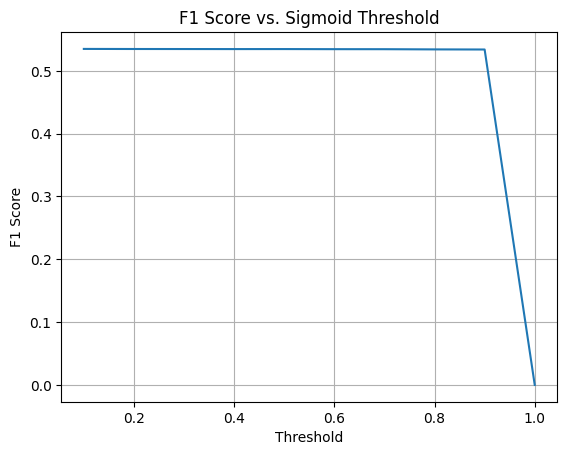

In [ ]:
bt = find_threshold(model, train_df_pt, optimizer, bce_loss_fn, ce_loss_fn, batch_size, device)

In [ ]:
# from sklearn.preprocessing import StandardScaler

# ss = StandardScaler()
# ss_col = [col for col in train_df.columns if col not in ['subject_id', 'date', 'sleep_date', 'lifelog_date'] + targets]
# train_df[ss_col] = ss.fit_transform(train_df[ss_col].values)
# test_df[ss_col] = ss.transform(test_df[ss_col].values)

In [ ]:
epochloop = tqdm(range(num_epochs), desc='Training')

for e in epochloop:
    train_loss, train_accuracy = train(model, train_df_pt, optimizer, bce_loss_fn, ce_loss_fn, batch_size, bt, device)
    epochloop.write(f'Epoch[{e+1}/{num_epochs}] Train Loss: {train_loss / len(train_df_pt):.4f} Train Acc: {train_accuracy / len(train_df_pt)}')

Training:  10%|█         | 1/10 [00:00<00:04,  1.89it/s]

Epoch[1/10] Train Loss: 3848.2827 Train Acc: 0.030013888888888885


Training:  20%|██        | 2/10 [00:00<00:03,  2.19it/s]

Epoch[2/10] Train Loss: 2607.5921 Train Acc: 0.0315


Training:  30%|███       | 3/10 [00:01<00:03,  2.22it/s]

Epoch[3/10] Train Loss: 1639.6616 Train Acc: 0.029208333333333333


Training:  40%|████      | 4/10 [00:01<00:02,  2.18it/s]

Epoch[4/10] Train Loss: 1701.5665 Train Acc: 0.02945833333333333


Training:  50%|█████     | 5/10 [00:02<00:02,  2.35it/s]

Epoch[5/10] Train Loss: 1096.2806 Train Acc: 0.02923611111111111


Training:  60%|██████    | 6/10 [00:02<00:01,  2.54it/s]

Epoch[6/10] Train Loss: 654.1899 Train Acc: 0.029513888888888888


Training:  70%|███████   | 7/10 [00:02<00:01,  2.81it/s]

Epoch[7/10] Train Loss: 729.4742 Train Acc: 0.028277777777777784


Training:  80%|████████  | 8/10 [00:03<00:00,  3.01it/s]

Epoch[8/10] Train Loss: 956.6756 Train Acc: 0.028624999999999998


Training:  90%|█████████ | 9/10 [00:03<00:00,  3.10it/s]

Epoch[9/10] Train Loss: 1277.2636 Train Acc: 0.028194444444444446


Training: 100%|██████████| 10/10 [00:03<00:00,  2.71it/s]

Epoch[10/10] Train Loss: 767.3623 Train Acc: 0.031222222222222228


In [ ]:
preds = predict(model, test_df_pt, sample_submission, seq_len)

# MLP

In [ ]:
targets = ['Q1','Q2','Q3','S1','S2','S3']

class MLPdataset_train(Dataset):
  def __init__(self, df, targets):
    self.targets = targets
    self.feature_cols = [col for col in df.columns if col not in ['subject_id', 'date', 'sleep_date', 'lifelog_date'] + targets]

    self.x = df[self.feature_cols].to_numpy(dtype=np.float32)
    self.y = df[targets].to_numpy(dtype=np.float32)

  def __len__(self):
    return len(self.x)

  def __getitem__(self, idx):
    return torch.tensor(self.x[idx]), torch.tensor(self.y[idx])

class MLPdataset_test(Dataset):
  def __init__(self, df, targets):
    self.targets = targets
    self.feature_cols = [col for col in df.columns if col not in ['subject_id', 'date', 'sleep_date', 'lifelog_date'] + targets]

    self.x = df[self.feature_cols].to_numpy(dtype=np.float32)

  def __len__(self):
    return len(self.x)

  def __getitem__(self, idx):
    return torch.tensor(self.x[idx])


class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout, device):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
# 모델 파라미터 설정
input_dim = 181
hidden_dim = 128
output_dim = 9  # Q1~Q3,S2~S3 = 1 , S1 = 3
batch_size=32
lr = 1e-4
dropout = 0.2
num_epochs = 100

# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

train_df = train_df.fillna(0)
teset_df = test_df.fillna(0)

model = MLP(input_dim, hidden_dim, output_dim, dropout, device)

bce_loss_fn = nn.BCEWithLogitsLoss()
ce_loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [ ]:
train_df_mlp = MLPdataset_train(train_df, targets)

train(model, train_df_mlp, optimizer, bce_loss_fn, ce_loss_fn, batch_size, device)

In [ ]:
test_df_mlp = MLPdataset_test(test_df, targets)

preds = predict(model, test_df_mlp, sample_submission, batch_size, device)

# MLP + TabNet

In [ ]:
class MLPwithTabNet(nn.Module):
  def __init__(self, input_dim, output_dim, tabnet_dim, mlp_hidden_dim, n_steps, dropout, device):
    super().__init__()

    self.tabnet = TabNetEncoder(
        input_dim=input_dim,
        output_dim=tabnet_dim,
        n_d=tabnet_dim,
        n_a=tabnet_dim,
        n_steps=n_steps,
        n_shared=2,
        n_independent=2,
        virtual_batch_size=64,
        momentum=0.02
        # cat_idxs=[],
        # cat_dims=[],
        # cat_emb_dim=1
    )

    self.mlp = nn.Sequential(
        nn.Linear(tabnet_dim, mlp_hidden_dim),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(mlp_hidden_dim, mlp_hidden_dim),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(mlp_hidden_dim, 64),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(64, output_dim)
        )

  def forward(self, x):
    tabnet_out, _  = self.tabnet(x)
    tabnet_out = tabnet_out[-1]
    outputs = self.mlp(tabnet_out)
    return outputs

In [ ]:
def train(model, train_dataset, optimizer, bce_loss_fn, ce_loss_fn, batch_size, device):
    model.train()
    loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for e in range(1, num_epochs + 1):
      train_loss = 0.0
      train_accuracy = 0.0
      for x_batch, y_batch in loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()

        output = model(x_batch)
        print(output)
        # Q1 ~ Q3, S2 ~ S3 - binary
        binary_logits = torch.cat([output[:, 0:3], output[:, 6:8]], dim=1)
        binary_target = torch.cat([y_batch[:, 0:3], y_batch[:, 4:6]], dim=1).float()
        loss_bce = bce_loss_fn(binary_logits, binary_target)

        binary_pred = (torch.sigmoid(torch.cat([output[:, 0:3], output[:, 6:8]], dim=1)) > 0.5).int()
        binary_correct = (binary_pred == binary_target).sum().item()
        binary_total = binary_target.numel()
        binary_acc = binary_correct / binary_total

        # S1 - multi
        multi_logits = output[:, 3:6]
        multi_target = y_batch[:, 3].long()
        loss_ce = ce_loss_fn(multi_logits, multi_target)

        multi_pred = multi_logits.argmax(dim=1)
        multi_correct = (multi_pred == multi_target).sum().item()
        multi_acc = multi_correct / x_batch.size(0)

        loss = loss_bce + loss_ce
        accuracy = (binary_acc + multi_acc) / 2

        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_accuracy += accuracy

      avg_loss = train_loss / len(loader)
      avg_accuracy = train_accuracy / len(loader)

      if e % 10 == 0 or e == 1 or e == num_epochs:
        print(f'Epoch {e}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}')

def predict(model, test_df, sample_submission, batch_size, device):
    model.eval()
    all_preds = []

    loader = DataLoader(test_df, batch_size=batch_size, shuffle=False)

    for batch in loader:
      x_batch = batch.to(device)
      with torch.no_grad():
        logits = model(x_batch)

        # Q1~Q3, S2~S3: binary -> sigmoid > 0.5
        binary_logits = torch.cat([logits[:, 0:3], logits[:, 6:8]], dim=1)
        binary_pred = (torch.sigmoid(binary_logits) > 0.5).int()

        # S1: multiclass (3 classes -> softmax + argmax)
        multi_logits = logits[:, 3:6]
        multi_class = torch.argmax(torch.softmax(multi_logits, dim=1), dim=1).unsqueeze(1)

        final_pred = torch.cat([binary_pred[:, :3], multi_class, binary_pred[:, 3:]], dim=1)
        all_preds.extend(final_pred.cpu().tolist())

    all_preds = np.array(all_preds)
    submission_out = sample_submission.copy()
    submission_out[['Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']] = all_preds

    return submission_out

In [ ]:
# 모델 파라미터 설정
input_dim = 181
mlp_hidden_dim = 128
output_dim = 8 # Q1~Q3,S2~S3 = 1 , S1 = 3
tabnet_dim = 64
n_steps = 5
dropout = 0.2
batch_size = 10
num_epochs = 50

# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

train_df = train_df.fillna(0)
teset_df = test_df.fillna(0)

bce_loss_fn = nn.BCEWithLogitsLoss()
ce_loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [ ]:
model = MLPwithTabNet(input_dim, output_dim, tabnet_dim, mlp_hidden_dim, n_steps, dropout, device)

In [ ]:
train(model, train_df_mlp, optimizer, bce_loss_fn, ce_loss_fn, batch_size, device)

# MLP-Mixer

In [ ]:
class MLPBlock(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim)
        )

    def forward(self, x):
        return self.block(x)

class MLPMixer(nn.Module):
    def __init__(self, input_dim, num_layers=2, token_mlp_dim=64, channel_mlp_dim=128, output_dim=6):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, input_dim)

        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.LayerNorm(input_dim),
                MLPBlock(input_dim, token_mlp_dim),
                nn.LayerNorm(input_dim),
                MLPBlock(input_dim, channel_mlp_dim)
            )
            for _ in range(num_layers)
        ])

        self.classifier = nn.Sequential(
            nn.LayerNorm(input_dim),
            nn.Linear(input_dim, output_dim)
        )

    def forward(self, x):
        x = self.input_proj(x)

        for layer in self.layers:
            norm1, token_mlp, norm2, channel_mlp = layer
            x = x + token_mlp(norm1(x))
            x = x + channel_mlp(norm2(x))

        return self.classifier(x)


# 결과 저장

In [ ]:
final = sample_submission[['subject_id','sleep_date','lifelog_date']].copy()
final['lifelog_date'] = pd.to_datetime(final['lifelog_date']).dt.date

final['id'] = final['subject_id'] + '_' + final['lifelog_date'].astype(str)
assert len(final) == len(preds['S1'])

target_list = ['Q1', 'Q2', 'Q3', 'S1','S2','S3']
for col in target_list:
  final[col] = preds[col].astype(int)

submission_final = final[['subject_id','sleep_date','lifelog_date', 'Q1','Q2','Q3','S1','S2','S3']]
submission_final.to_csv('submission_final.csv',index=False)

from google.colab import files
files.download("submission_final.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>